In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from random import choices
import random

### Creating classes for each item

In [81]:
class Information:
    def __init__(self):
        self.factual = choices(population=[True, False], weights=[0.5, 0.5])[0]
        self.fact_checked = False
        self.lifecycle = 7
        self.active = True
        self.extraterrestrial = choices(population=[True, False], weights=[0.01, 0.99])[0]

class Agent:
    def __init__(self, id):
        self.id = id
        self.forceful_agent = choices(population=[True, False], weights=[0.2, 0.8])[0]
        self.right_leaning = choices(population=[True, False], weights=[0.5, 0.5])[0]
        self.religious = choices(population=[True, False], weights=[0.65, 0.35])[0]
        self.connection_ids = []
        self.information = []

### Variable initialisation

In [82]:
n_agents = 1000
agent_ids = []
agents = []

# creating agents
for x in range(n_agents):
    id = x
    newAgent = Agent(id=id)
    agent_ids.append(id)
    agents.append(newAgent)

# creating information
for agent in agents:

    # add 10 pieces of information to each agent
    for x in range(10):
        info = Information()
        agent.information.append(info)

# creating connections between agents
for agent in agents:
    # each agent connects to 10 other agents
    connections = random.sample(agent_ids, 10)
    agent.connection_ids = connections

### Creating simulation loop

In [83]:
def interact(agents, agent_id1, agent_id2, only_unverified=False):


    agent1 = agents[agent_id1]
    agent2 = agents[agent_id2]

    agent1_type = agent1.forceful_agent
    agent2_type = agent2.forceful_agent

    if ((agent1_type==False) and (agent2_type==True)): # if 2 is forceful
        
        agent1.infrmation = agent2.information.copy()

    elif ((agent1_type==True) and (agent2_type==False)): # if 1 is forceful
        
        agent2.information = agent1.information.copy()

    elif ((agent1_type==False) and (agent2_type==False)): #if both regular

        agent1_toshare = random.sample(agent1.information, min(5, len(agent1.information)))
        agent2_toshare = random.sample(agent2.information, min(5, len(agent2.information)))

        for info in agent1_toshare:

            if only_unverified == True and info.fact_checked == False:
                continue

            if info.active == False:
                continue

            if (agent2.right_leaning == True or agent2.religious == True) and info.extraterrestrial == True:
                
                should_continue = choices(population=[True, False], weights=[0.35, 0.45])[0]

                if should_continue == False:
                    continue

            agent1.information.remove(info)
            agent2.information.append(info)

        for info in agent2_toshare:

            if only_unverified == True and info.fact_checked == False:
                continue

            if info.active == False:
                continue

            if (agent1.right_leaning == True or agent1.religious == True) and info.extraterrestrial == True:
                
                should_continue = choices(population=[True, False], weights=[0.35, 0.45])[0]

                if should_continue == False:
                    continue

            agent2.information.remove(info)
            agent1.information.append(info)


    agents[agent_id1] = agent1
    agents[agent_id2] = agent2
    
    return agents

In [84]:
def calculate_et_amount(agents):

    et_count = 0

    for agent in agents:

        for info in agent.information:
            if info.extraterrestrial == True:
                et_count += 1

    return et_count

def calculate_et_amount_pct(agents):

    info_count = 0

    for agent in agents:
        for info in agent.information:
            info_count += 1

    et_count = calculate_et_amount(agents)

    et_pct = et_count / info_count

    return et_pct

def calculate_num_ppl_et_belief(agents):

    et_belief_count = 0

    for agent in agents:

        et_belief = False

        for info in agent.information:
            if info.extraterrestrial == True:
                et_belief = True

        if et_belief == True:
            et_belief_count += 1

    return et_belief_count

def calculate_new_beliefs(previous_num_ppl_et_belief, new_num_ppl_et_belief):
    return new_num_ppl_et_belief - previous_num_ppl_et_belief

In [85]:
days = 100
spread_steps = 4

# variables to save metric per day for time series 
day_et_amount = [] # amount of extra terrestrial beliefs held by day
day_et_amount_new = [] # amount of extra terrestrial beliefs newly spread by day
day_et_amount_pct = [] # percentage of extra terrestrial beliefs held by day
day_agents_et_belief = [] # number of agents with extra terrestrial beliefs by day

day_et_amount.append(calculate_et_amount(agents))
day_et_amount_pct.append(calculate_et_amount_pct(agents))
day_agents_et_belief.append(calculate_num_ppl_et_belief(agents))

for day in range(days):
    
    for spread_step in range(spread_steps):

        if spread_step == 1 or spread_step == 3:
            only_unverified = True
        else:
            only_unverified = False

        for agent_id in agent_ids:

            for connection in agents[agent_id].connection_ids:

                agents = interact(agents, agent_id, connection, only_unverified=only_unverified)

            # get three more random connections
            three_random_agents_found = False
            three_random_agents_found_ids = []

            while three_random_agents_found == False:
                random_agent_id = random.choice(agent_ids)

                if random_agent_id not in agents[agent_id].connection_ids and random_agent_id != agent_id:
                    three_random_agents_found_ids.append(random_agent_id)

                if len(three_random_agents_found_ids) == 3:
                    three_random_agents_found = True

            for random_connection in three_random_agents_found_ids:

                agents = interact(agents, agent_id, random_connection, only_unverified=only_unverified)

    # information lifecycle
    for agent_id in agent_ids:

        # see if info becomes old
        for info in agents[agent_id].information:
            info.lifecycle -= 1

            if info.lifecycle <= 0:
                info.active = False

        # fact check info
        for info in agents[agent_id].information:

            if info.fact_checked == False and info.active == True:

                if info.factual == True:
                    fact_check = choices(population=[True, False], weights=[0.75, 0.25])[0]
                else:
                    fact_check = choices(population=[True, False], weights=[0.5, 0.5])[0]

                if fact_check == True:
                    info.fact_checked = True

        # new info chance
        if agents[agent_id].forceful_agent == True:
            
            learn_new_info = choices(population=[True, False], weights=[0.65, 0.35])[0]

            if learn_new_info:
                agents[agent_id].information.append(Information())

    # calculate metrics
    day_et_amount.append(calculate_et_amount(agents))
    day_et_amount_pct.append(calculate_et_amount_pct(agents))
    day_agents_et_belief.append(calculate_num_ppl_et_belief(agents))

    day_et_amount_new.append(calculate_new_beliefs(day_agents_et_belief[day], day_agents_et_belief[day+1]))

### Results analysis

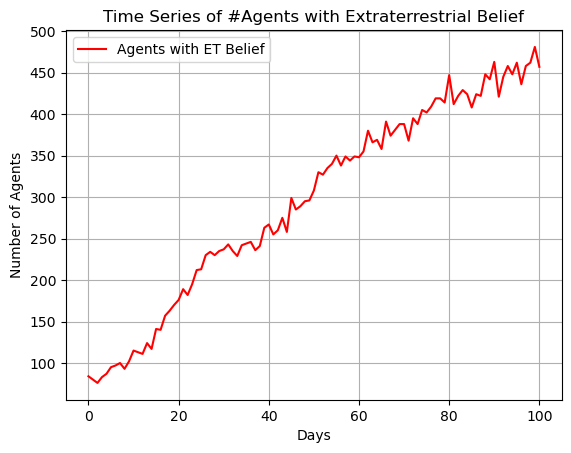

In [86]:
# series of agents_et_belief

x = range(days+1)
y = day_agents_et_belief

plt.plot(x, y, color='red', label='Agents with ET Belief')
plt.xlabel('Days')
plt.ylabel('Number of Agents')
plt.title('Time Series of #Agents with Extraterrestrial Belief')
plt.grid(True)
plt.legend()
plt.show()

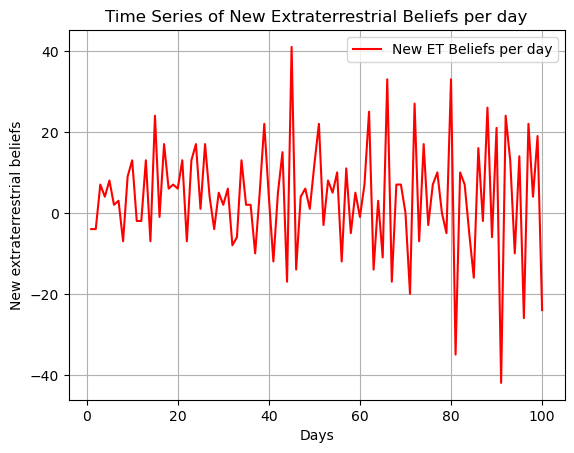

In [87]:
# series of new et beliefs by day

x = range(1, days+1)
y = day_et_amount_new

plt.plot(x, y, color='red', label='New ET Beliefs per day')
plt.xlabel('Days')
plt.ylabel('New extraterrestrial beliefs')
plt.title('Time Series of New Extraterrestrial Beliefs per day')
plt.grid(True)
plt.legend()
plt.show()

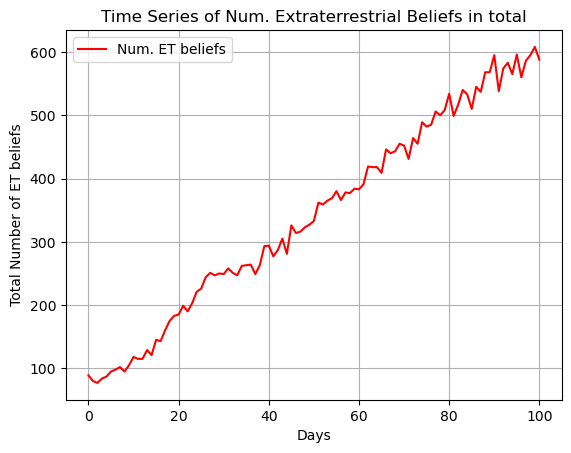

In [88]:
# series of amount of et beliefs by day

x = range(days+1)
y = day_et_amount

plt.plot(x, y, color='red', label='Num. ET beliefs')
plt.xlabel('Days')
plt.ylabel('Total Number of ET beliefs')
plt.title('Time Series of Num. Extraterrestrial Beliefs in total')
plt.grid(True)
plt.legend()
plt.show()

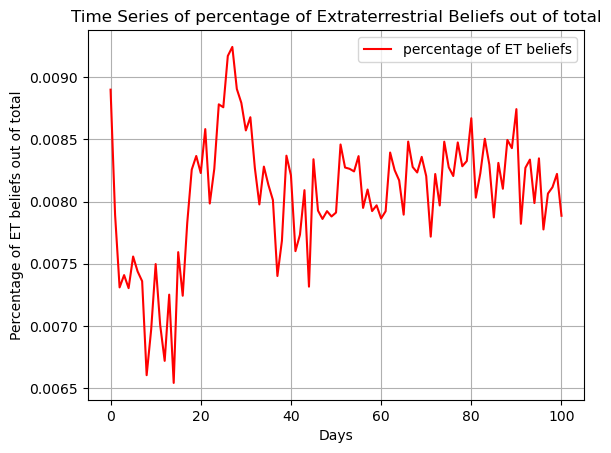

In [89]:
# series of amount of et beliefs by day as a percentage

x = range(days+1)
y = day_et_amount_pct

plt.plot(x, y, color='red', label='percentage of ET beliefs')
plt.xlabel('Days')
plt.ylabel('Percentage of ET beliefs out of total')
plt.title('Time Series of percentage of Extraterrestrial Beliefs out of total')
plt.grid(True)
plt.legend()
plt.show()

In [90]:
et_beliefs = 0
et_beliefs_false = 0

for agent in agents:
    for info in agent.information:

        if info.extraterrestrial == True:
            et_beliefs += 1

            if info.factual == False:
                et_beliefs_false += 1

print(f"The percentage of false ET informations held is: {et_beliefs_false/et_beliefs*100}%")

The percentage of false ET informations held is: 53.06122448979592%
